# Introduction to Astrometry

### Dora Föhring, University of Hawaii Institute for Astronomy

Aim: To measure the position and uncertainty of a Near Earth Asteroid

## 0. Prerequisites

pip install astroquery

In [134]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from astropy import wcs
from astroquery.gaia import Gaia
import pdb
## make matplotlib appear in the notebook rather than in a new window
%matplotlib inline

### 0.1 Directory Set up & Display Image

In [135]:
datadir = '/Users/dorafohring/Desktop/2016HO3/'
objname  = '2016HO3'

In [136]:
def plotfits(imno):
    img = fits.open(datadir+objname+'_{0:02d}.fits'.format(numb))[0].data

    f = plt.figure(figsize=(10,12))
    im = plt.imshow(img, cmap='hot')
    im = plt.imshow(img[480:560, 460:540], cmap='hot')
    plt.clim(1800, 2800)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.savefig("figure{0}.png".format(imno))
    plt.show()

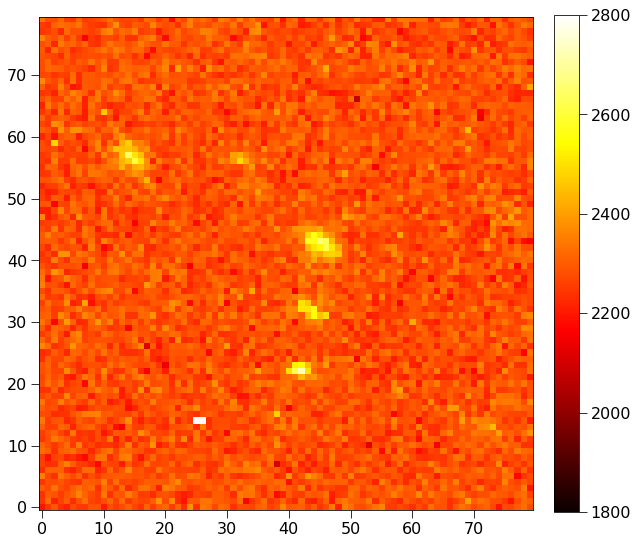

In [137]:
numb = 1 
plotfits(numb)

## 1. Centroiding on Images

Write a text file with image centers.
Write code to open each image and extract centroid position from previous exercise.
Save results in a text file.

In [156]:
centers = np.array([[502,501], [502,501]])
np.savetxt('centers.txt', centers, fmt='%i')
centers = np.loadtxt('centers.txt', dtype='int')

In [157]:
searchr = 5

### 1.1 Center of Mass

In [158]:
def cent_weight(n):
    """
    Assigns centroid weights
    """
    wghts=np.zeros((n),np.float)
    for i in range(n):
        wghts[i]=float(i-n/2)+0.5
    return wghts

def calc_CoM(psf, weights):
    """
    Finds Center of Mass of image
    """
    cent=np.zeros((2),np.float)
    temp=sum(sum(psf))
    cent[0]=sum(sum(psf)*weights)/temp
    cent[1]=sum(sum(psf.T)*weights)/temp
    return cent

In [159]:
centlist = []
for i, center in enumerate(centers):
    image = fits.open(datadir+objname+'_{0:02d}.fits'.format(i+1))[0].data
    searchbox = image[center[0]-searchr : center[0]+searchr, center[1]-searchr : center[1]+searchr]
    boxlen = len(searchbox)
    weights = cent_weight(boxlen)
    cen_offset = calc_CoM(searchbox, weights)
    centlist.append(center + cen_offset)

In [285]:
print(centlist[0])

[ 502.01468185  501.00082137]


## 2. Identifying Stars in the Field

### 2.1. Image Maxima

Create a new image using an mapping arc sinh that captures the full dynamic range effectively.  
Locate lower and upper bounds that should include only stars.  
Refine the parameters to optimize the extraction of stars from background.

In [286]:
import skimage.morphology as morph
import skimage.exposure as skie
import scipy.ndimage as ndimage

In [287]:
no = 1
image = fits.open(datadir+objname+'_{0:02d}.fits'.format(no))[0].data

In [288]:
limg = np.arcsinh(image)
limg = limg / limg.max()
low = np.percentile(limg, 0.25)
high = np.percentile(limg, 99.5)
opt_img  = skie.exposure.rescale_intensity(limg, in_range=(low,high))
gimg = ndimage.gaussian_filter(opt_img, sigma=(5, 5), order=0)

Create a new image that is scaled between the lower and upper limits for displaying the star map.  
Search the arcsinh-stretched original image for local maxima and catalog those brighter than a threshold that is adjusted based on the image.

In [289]:
lm = morph.local_maxima(gimg)
x1, y1 = np.where(lm.T == True)
v = limg[(y1,x1)]
lim = 0.7

## x2 and y2 are pixel indices
x2, y2 = x1[v > lim], y1[v > lim]

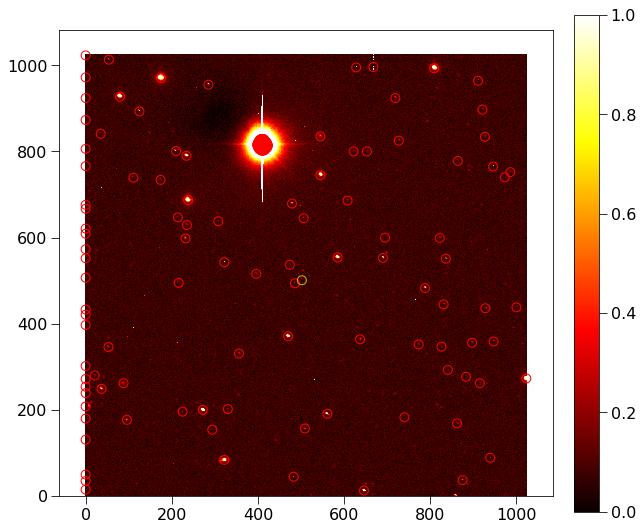

In [295]:
f = plt.figure(figsize=(10,12))
plt.imshow(opt_img, cmap='hot')
plt.colorbar(fraction=0.046, pad=0.04)
plt.scatter(x2, y2, s=80, facecolors='none', edgecolors='r')
plt.scatter(502.01468185, 501.00082137, s=80, facecolors='none', edgecolors='y' )
plt.show()

## 3. Converting pixel coordinates to WCS

In [178]:
def load_wcs_from_file(filename, xx, yy):
    # Load the FITS hdulist using astropy.io.fits
    hdulist = fits.open(filename)

    # Parse the WCS keywords in the primary HDU
    w = wcs.WCS(hdulist[0].header)

    # Print out the "name" of the WCS, as defined in the FITS header
    print(w.wcs.name)

    # Print out all of the settings that were parsed from the header
    w.wcs.print_contents()

    # Three pixel coordinates of interest.
    # Note we've silently assumed a NAXIS=2 image here
    targcrd = np.array([centlist[0]], np.float_)
    
    starscrd = np.array([xx, yy], np.float_)

    # Convert pixel coordinates to world coordinates
    # The second argument is "origin".
    tworld = w.wcs_pix2world(targcrd, 0)
    sworld = w.wcs_pix2world(starscrd.T, 0)
    print(tworld)
    
    return w, sworld


[[ 193.34296097   33.86170303]]


Find position of Asteroid in WCS

In [263]:
wparams, scoords = load_wcs_from_file(datadir+objname+'_{0:02d}.fits'.format(1), x2, y2)


[[ 193.34296097   33.86170303]]


In [264]:
print(scoords)

[[ 193.41680571   33.80228606]
 [ 193.41680758   33.8047305 ]
 [ 193.41680898   33.80656383]
 ..., 
 [ 193.27169581   33.89235526]
 [ 193.26967123   33.85397618]
 [ 193.26630634   33.83380725]]


## 3. Matching

### 3.1 Get astrometric catalog

In [265]:
job = Gaia.launch_job_async("SELECT * \
FROM gaiadr1.gaia_source \
WHERE CONTAINS(POINT('ICRS',gaiadr1.gaia_source.ra,gaiadr1.gaia_source.dec),CIRCLE('ICRS', 193.34, 33.86, 0.08))=1;" \
, dump_to_file=True)

print (job)

Launched query: 'SELECT * FROM gaiadr1.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr1.gaia_source.ra,gaiadr1.gaia_source.dec),CIRCLE('ICRS', 193.34, 33.86, 0.08))=1;'
Retrieving async. results...
Jobid: 1515849713603O
Phase: None
Owner: None
Output file: async_20180113032153.vot
Results: None


In [266]:
r = job.get_results()
print (r['source_id'], r['ra'], r['dec'])
print(type(r['ra']))

     source_id     
-------------------
1515770241672792704
1515751378176545408
1515769623197411456
1515769378384464768
1515751236442583296
1515751270802228736
1515769206585764480
1515751305162058752
1515764258783437696
1515751373881536256
                ...
1515769240945469952
1515750995924397696
1515750995924397824
1515763880826316416
1515762850034149376
1515757936591587328
1515762987473110656
1515757558634354304
1515756325978649728
1515762678235367040
1515769309667939712
Length = 36 rows         ra        
       deg        
------------------
193.31962507821265
193.34217139504767
193.35493968928526
193.38327685694409
193.38505967616862
193.33814860467297
193.35475877015173
193.35034321839012
193.26059009959198
193.34280810593697
               ...
193.36581521621554
193.35734586149439
193.25293663775915
193.26330158841628
193.40686364810929
193.28605697007046
193.40878840515927
  193.432503454244
193.29670644446338
193.39456770646817
Length = 36 rows        dec        
       deg 

Convert Gaia WCS coordinates to pixels

## 3.2 Perform Match

In [275]:
ra  = np.array(r['ra'])
dec = np.array(r['dec'])

xpix, ypix = wparams.wcs_world2pix(ra, dec, 0)

In [276]:
skyvals = np.array([np.round(xpix).astype(int), np.round(ypix).astype(int)]).T

#np.array([x2, y2]).T

skycor = np.zeros([1024,1024])


In [277]:
skymasked = np.ma.masked_array(skyvals, mask=(1024<skyvals) )
skymasked = np.ma.masked_array(skymasked, mask=(skyvals<0) )
skymasked = np.ma.mask_rowcols(skymasked, axis=0)
skypix = skymasked[~skymasked.mask]
skypix = np.array(skypix.reshape(int(len(skypix)/2), 2 ))

In [278]:
skyframe = np.zeros([1024,1024])
skyframe[skypix[:,1], skypix[:,0]] = 1

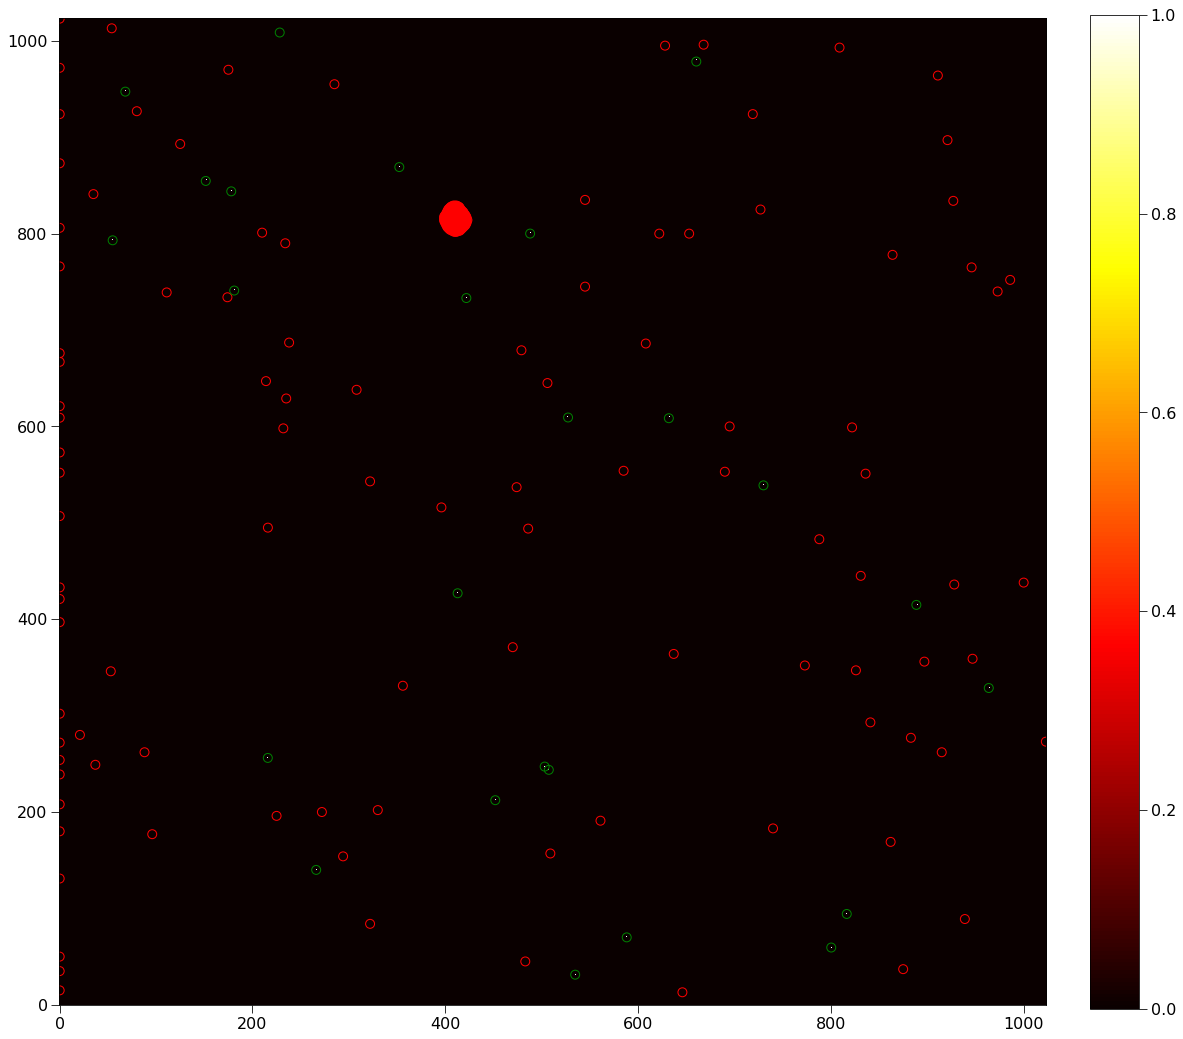

In [279]:
f = plt.figure(figsize=(20,22))
plt.imshow(opt_img, cmap='hot')
plt.colorbar(fraction=0.046, pad=0.04)
plt.scatter(x2, y2, s=80, facecolors='none', edgecolors='r')
plt.scatter(xpix, ypix, s=80, facecolors='none', edgecolors='g')
plt.imshow(skyframe, cmap='hot')
plt.show()

Match

In [280]:
from scipy import signal

corr = signal.correlate2d(skyframe, np.array([ra,dec]).T, mode='same')


In [281]:
np.unravel_index(corr.argmax(), corr.shape)


(15, 535)

Shift

In [297]:
targshifted = np.array([ 193.34296097, 33.86170303]) + np.unravel_index(corr.argmax(), corr.shape)

Convert shifted coordinate into WCS

In [ ]:
wparams, scoords = load_wcs_from_file(datadir+objname+'_{0:02d}.fits'.format(1), targshifted[0], targshifted[1])